In [1]:
from collections import deque

import networkx as nx

class TemporalGraph:
    def __init__(self):
        self.nodes = set()
        self.graph = nx.DiGraph()

    def add_edge(self, u, v, t):
        self.nodes.add(u)
        self.nodes.add(v)
        self.graph.add_edge(u, v, timestamp=t)

    def get_edges_greater_than_time(self, node, t):
        neighbors = []
        for neighbor, edge_data in self.graph[node].items():
            if edge_data['timestamp'] > t:
                neighbors.append((neighbor, edge_data['timestamp']))
        return neighbors
    
    def get_nodes(self):
        return list(self.nodes)

In [2]:
def bfs_temporal_paths(graph, start_node, max_path_len=None):
    queue = deque([[(start_node, -float('inf'))]])
    all_paths = []

    while queue:
        path = queue.popleft()
        current_node, current_time = path[-1]

        neighbors = graph.get_edges_greater_than_time(current_node, current_time)

        if not neighbors or (max_path_len is not None and len(path) >= max_path_len):
            all_paths.append(path)
            continue

        for next_node, next_time in neighbors:
            new_path = path + [(next_node, next_time)]
            queue.append(new_path)

    return all_paths

In [3]:
from test import read_data

reddit_edges = read_data('reddit')

In [4]:
temporal_graph = TemporalGraph()

for u, v, t in reddit_edges:
    temporal_graph.add_edge(u, v, t)

In [5]:
from concurrent.futures import ThreadPoolExecutor

all_paths_for_all_nodes = []

with ThreadPoolExecutor(max_workers=12) as executor:
    futures = {
        node: executor.submit(bfs_temporal_paths, temporal_graph, node) 
        for node in temporal_graph.get_nodes()
    }

    for node, future in futures.items():    
        try:
            node_paths = future.result()
            all_paths_for_all_nodes += node_paths
            print(f"Got paths for node {node}")
        except Exception as e:
            print(f"Error processing node {node}: {e}")

Got paths for node 1
Got paths for node 2
Got paths for node 3
Got paths for node 4
Got paths for node 5
Got paths for node 6
Got paths for node 7
Got paths for node 8
Got paths for node 9
Got paths for node 10
Got paths for node 11
Got paths for node 12
Got paths for node 13
Got paths for node 14
Got paths for node 15
Got paths for node 16
Got paths for node 17
Got paths for node 18
Got paths for node 19
Got paths for node 20
Got paths for node 21
Got paths for node 22
Got paths for node 23
Got paths for node 24
Got paths for node 25
Got paths for node 26
Got paths for node 27
Got paths for node 28
Got paths for node 29
Got paths for node 30
Got paths for node 31
Got paths for node 32
Got paths for node 33
Got paths for node 34
Got paths for node 35
Got paths for node 36
Got paths for node 37
Got paths for node 38
Got paths for node 39
Got paths for node 40
Got paths for node 41
Got paths for node 42
Got paths for node 43
Got paths for node 44
Got paths for node 45
Got paths for node 

In [7]:
paths = [[node for node, time in path] for path in all_paths_for_all_nodes]

In [36]:
path_lens = [len(path) for path in paths]

In [37]:
import numpy as np

min(path_lens), max(path_lens), np.mean(path_lens), np.median(path_lens)

(2, 17, 7.101817890648165, 7.0)

In [95]:
from gensim.models import Word2Vec

str_paths = [[str(node) for node in walk] for walk in paths]
embedding_model = Word2Vec(str_paths, min_count=1, vector_size=256, workers=3, window=5, sg=1)

In [96]:
def get_embedding_for_all_nodes(embedding_model):
    return {int(node): embedding_model.wv[node] for node in embedding_model.wv.index_to_key}

In [97]:
embedding_dict = get_embedding_for_all_nodes(embedding_model)

In [98]:
import pandas as pd

df = pd.DataFrame(reddit_edges, columns=['u', 'i', 't'])

df['pair'] = df.apply(lambda row: tuple(sorted([row['u'], row['i']])), axis=1)
interaction_counts = df['pair'].value_counts()
interaction_dict = interaction_counts.to_dict()

In [108]:
import random
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import spearmanr, pearsonr

def validate_embeddings(embedding_dict, interaction_dict, distance_method):
    random.seed(42)
    filtered_pairs = [(i, j) for i, j in interaction_dict.keys() if i != j]
    
    similarities = []
    interaction_counts = []
    
    for i, j in filtered_pairs:
        if distance_method == 'euclidean':
            sim = euclidean(embedding_dict[i], embedding_dict[j])
        elif distance_method == 'cosine':
            sim = cosine(embedding_dict[i], embedding_dict[j])
        else:
            raise Exception("Invalid distance_method")
            
        similarities.append(sim)
        
        interaction_counts.append(interaction_dict[(i, j)])
    
    pearson_corr, _ = pearsonr(similarities, interaction_counts)
    spearman_corr, _ = spearmanr(similarities, interaction_counts)
    
    return similarities, interaction_counts, pearson_corr, spearman_corr

In [100]:
distances_euclidean, interaction_counts_euclidean, pearson_corr_euclidean, spearman_corr_euclidean = validate_embeddings(
    embedding_dict, interaction_dict, 'euclidean'
)

In [101]:
print(f"Pearson Correlation: {pearson_corr_euclidean}")
print(f"Spearman Correlation: {spearman_corr_euclidean}")

Pearson Correlation: 0.06537708048149429
Spearman Correlation: 0.14046541575930363


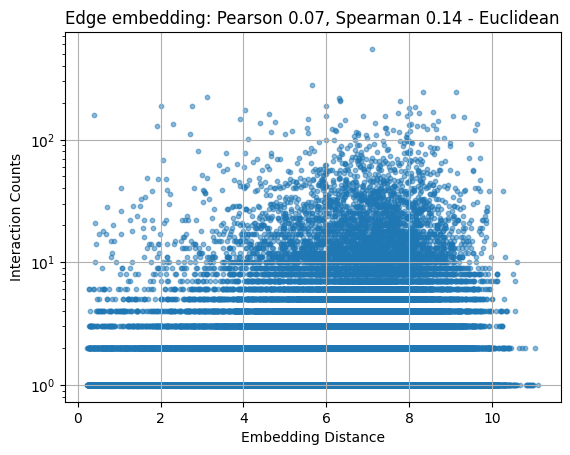

In [102]:
import matplotlib.pyplot as plt

plt.scatter(distances_euclidean, interaction_counts_euclidean, alpha=0.5, s=10)
plt.title(f"Edge embedding: Pearson {pearson_corr_euclidean:.2f}, Spearman {spearman_corr_euclidean:.2f} - Euclidean")
plt.xlabel("Embedding Distance")
plt.ylabel("Interaction Counts")
plt.yscale('log')
plt.grid(True)
plt.savefig('plots/edge_embedding_skipgram.png')
plt.show()

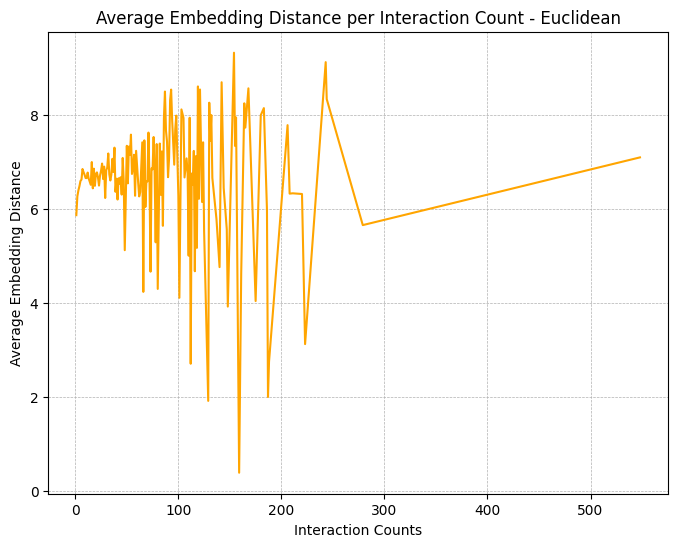

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

distance_by_interaction = defaultdict(list)

for distance, interaction in zip(distances_euclidean, interaction_counts_euclidean):
    distance_by_interaction[interaction].append(distance)

interaction_counts = sorted(distance_by_interaction.keys())
average_distances = [
    np.mean(distance_by_interaction[interaction]) for interaction in interaction_counts
]

plt.figure(figsize=(8, 6))
plt.plot(interaction_counts, average_distances, color='orange', linewidth=1.5, label='Average Trend')

plt.title("Average Embedding Distance per Interaction Count - Euclidean")
plt.xlabel("Interaction Counts")
plt.ylabel("Average Embedding Distance")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig('plots/average_embedding_distance_per_interaction.png')
plt.show()


In [104]:
distances_cosine, interaction_counts_cosine, pearson_corr_cosine, spearman_corr_cosine = validate_embeddings(
    embedding_dict, interaction_dict, 'cosine'
)

In [105]:
print(f"Pearson Correlation: {pearson_corr_cosine}")
print(f"Spearman Correlation: {spearman_corr_cosine}")

Pearson Correlation: 0.06328026769375185
Spearman Correlation: 0.12920208567952784


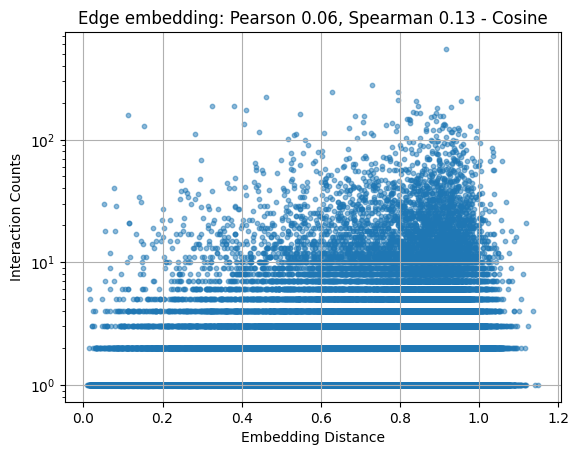

In [106]:
import matplotlib.pyplot as plt

plt.scatter(distances_cosine, interaction_counts_cosine, alpha=0.5, s=10)
plt.title(f"Edge embedding: Pearson {pearson_corr_cosine:.2f}, Spearman {spearman_corr_cosine:.2f} - Cosine")
plt.xlabel("Embedding Distance")
plt.ylabel("Interaction Counts")
plt.yscale('log')
plt.grid(True)
plt.savefig('plots/edge_embedding_skipgram.png')
plt.show()

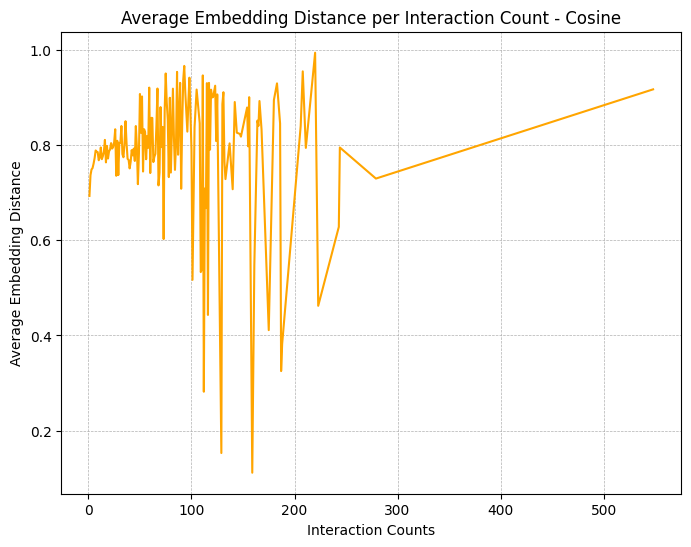

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

distance_by_interaction = defaultdict(list)

for distance, interaction in zip(distances_cosine, interaction_counts_cosine):
    distance_by_interaction[interaction].append(distance)

interaction_counts = sorted(distance_by_interaction.keys())
average_distances = [
    np.mean(distance_by_interaction[interaction]) for interaction in interaction_counts
]

plt.figure(figsize=(8, 6))
plt.plot(interaction_counts, average_distances, color='orange')

plt.title("Average Embedding Distance per Interaction Count - Cosine")
plt.xlabel("Interaction Counts")
plt.ylabel("Average Embedding Distance")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig('plots/average_embedding_distance_per_interaction.png')
plt.show()